In [69]:
%matplotlib inline
import pandas as pd
import numpy as np

import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

from scipy.stats import (pearsonr, median_abs_deviation) 

from yellowbrick.cluster import (SilhouetteVisualizer, KElbowVisualizer)
from yellowbrick.style.palettes import color_palette
import matplotlib.pyplot as plt
import plotly.express as px
import matplotlib.cm as cm
import seaborn as sns

from sklearn.preprocessing import (StandardScaler, MinMaxScaler, Normalizer, RobustScaler, OneHotEncoder, LabelEncoder)
from sklearn.metrics import (silhouette_samples, silhouette_score)

from sklearn.cluster import (KMeans)

from warnings import filterwarnings
sns.set_style("whitegrid")
set_nb_theme("chesterish")
filterwarnings("ignore")
jtplot.style(theme='chesterish', context='notebook', ticks=True, grid=True)

In [70]:
applicants = pd.read_csv("applicants_cleaned.csv")
loan = pd.read_csv("loan_details.csv")

print(f"applicants shape: {applicants.shape}",
      f"loan shape: {loan.shape}"
     )

applicants shape: (1000, 12) loan shape: (1000, 11)


In [71]:
applicants.head()

,applicant_id,age,gender,marital_status,no_of_dependents,housing,residency(years),employment_status,at_least_employment(years),at_most_employment(years),foreign_worker,ac_balance(savings)
0,1469590,67,male,single,1,own,4,skilled employee / official,7.0,2.746,1,1.052016
1,1203873,22,female,divorced/separated/married,1,own,2,skilled employee / official,1.0,4.000,1,1.000000
2,1432761,49,male,single,2,own,3,unskilled - resident,4.0,7.000,1,1.000000
3,1207582,45,male,single,2,for free,4,skilled employee / official,4.0,7.000,1,1.000000
4,1674436,53,male,single,2,for free,4,skilled employee / official,1.0,4.000,1,1.000000


In [72]:
loan.head()

,applicant_id,loan_taken_over(months),purpose,loan_amt,emi_rate(percent),property,has_coapplicant,has_guarantor,existing_loans(total),loan_history,risk
0,1469590,6,electronic equipment,1169000,4,real estate,0,0,2,critical/pending loans at other banks,0
1,1203873,48,electronic equipment,5951000,2,real estate,0,0,1,existing loans paid back duly till now,1
2,1432761,12,education,2096000,2,real estate,0,0,1,critical/pending loans at other banks,0
3,1207582,42,FF&E,7882000,2,building society savings agreement/life insurance,0,1,1,existing loans paid back duly till now,0
4,1674436,24,new vehicle,4870000,3,car or other,0,0,2,delay in paying off loans in the past,1


## Combine data:

In [73]:
data = applicants.merge(loan)
data.sample(3)

,applicant_id,age,gender,marital_status,no_of_dependents,housing,residency(years),employment_status,at_least_employment(years),at_most_employment(years),...,loan_taken_over(months),purpose,loan_amt,emi_rate(percent),property,has_coapplicant,has_guarantor,existing_loans(total),loan_history,risk
400,1393314,39,male,married/widowed,1,own,4,skilled employee / official,2.806,1.0,...,18,electronic equipment,1473000,3,real estate,0,0,1,existing loans paid back duly till now,0
117,1206049,27,female,divorced/separated/married,1,rent,3,skilled employee / official,2.806,1.0,...,10,FF&E,2132000,2,real estate,1,0,2,critical/pending loans at other banks,0
234,1570458,42,male,single,2,own,1,unskilled - resident,4.000,7.0,...,4,electronic equipment,1544000,2,real estate,0,0,3,critical/pending loans at other banks,0


In [74]:
data.var()

applicant_id                  5.229288e+10
age                           1.294013e+02
no_of_dependents              1.311061e-01
residency(years)              1.218193e+00
at_least_employment(years)    5.378183e+00
at_most_employment(years)     3.461475e+00
foreign_worker                3.566667e-02
ac_balance(savings)           1.640835e-01
loan_taken_over(months)       1.454150e+02
loan_amt                      7.967843e+12
emi_rate(percent)             1.251523e+00
has_coapplicant               3.935836e-02
has_guarantor                 4.934535e-02
existing_loans(total)         3.336847e-01
risk                          2.102102e-01
dtype: float64

## Dropping zero (almost zero) Variance and redundant columns:

In [75]:
data.drop(columns=["foreign_worker", "has_coapplicant", "marital_status", 
                   "has_guarantor", "no_of_dependents", "ac_balance(savings)"
                  ], 
          inplace=True
         )

## EDA:

## Male vs Female Credit Risk.

In [76]:
print(data['gender'].value_counts(), data['risk'].value_counts(), sep = "\n\n")

male      690
female    310
Name: gender, dtype: int64

0    700
1    300
Name: risk, dtype: int64


In [77]:
# -- Male and female with low credit risk -- 
filter_male_low = (data['gender']=='male') & (data['risk'] == 0)
filter_female_low = (data['gender'] == 'female') & (data['risk'] == 0)

# -- Male and female with high credit risk -- 
filter_male = (data['gender']=='male') & (data['risk'] == 1)
filter_female = (data['gender'] == 'female') & (data['risk'] == 1)
# data.loc[filter_male]

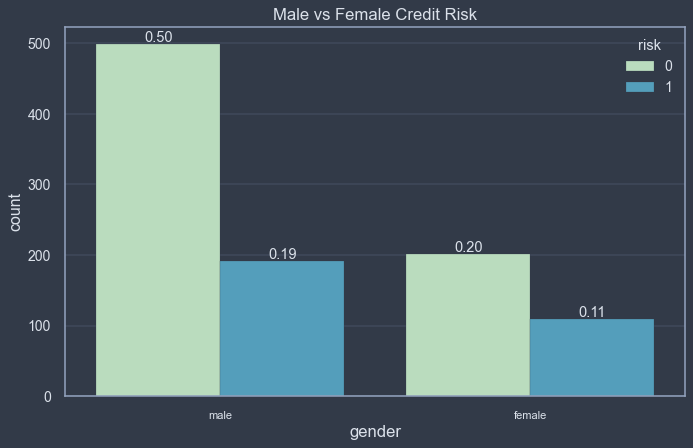

--------------------------------------------------------------------------------
Male low credit risk: 499 applicants. 
Female low credit risk: 201 applicants. 

Male high credit risk: 191 applicants. 
Female high credit risk: 109 applicants.


In [78]:
# -- Visualization --
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)
ax = sns.countplot(x="gender", hue = "risk", data=data, palette="GnBu")
ax.set_xticklabels(ax.get_xticklabels(), size=10)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3, 
            '{:1.2f}'.format(height/data.shape[0]), ha="center"
           )
plt.xlabel("gender", size=15)
plt.title("Male vs Female Credit Risk", size=15)
plt.show()

print('-'*80)

print(f"Male low credit risk: {data.loc[filter_male_low].shape[0]} applicants.",
      f"\nFemale low credit risk: {data.loc[filter_female_low].shape[0]} applicants.",
      f"\n\nMale high credit risk: {data.loc[filter_male].shape[0]} applicants.",
      f"\nFemale high credit risk: {data.loc[filter_female].shape[0]} applicants."
     )

### Notes:

0 = __Low credit risk__ i.e high chance of paying back the loan amount.  
 - There are total __499 men__ and __201 females__ with low credit risk.
 - Graph clearly shows that men are highly likely to pay their loans and has a great difference between men with high credit risk and men with low credit risk.

<br>

1 = __High credit risk__ i.e low chance of paying back the loan amount.
 - There are total __191 males__ and __109 females__ with high credit risk. 

<br>
 The ratio of male vs female applicants for the loan is unbalanced or not even.<br>
 There are 690 male and 310 female applicants.

### Employement Status vs Credit Risk:

In [79]:
data["employment_status"].value_counts()

skilled employee / official                                         630
unskilled - resident                                                200
management / self-employed / highly qualified employee / officer    148
unemployed / unskilled - non-resident                                22
Name: employment_status, dtype: int64

- __"skilled employee / official"__ and __"management / self-employed / highly qualified employee / officer"__ two categories seems to be same.
- Because people in first category has employement (job): source of earning.
- Second category shows that there are people who may have their own businesses or are self employed, and has source of earnings as well.
- Therefore I'm combining these two categories here.

In [80]:
data["employment_status"] = data['employment_status'].str.replace("unemployed / unskilled - non-resident", "unemployed")
data["employment_status"] = data['employment_status'].str.replace("skilled employee / official", "officer")
data["employment_status"] = data["employment_status"].str.replace("management / self-employed / highly qualified employee / officer",
                                                                  "officer")
data["employment_status"] = data["employment_status"].str.replace("unskilled - resident", "unskilled-resident")
data.employment_status.value_counts()

officer               778
unskilled-resident    200
unemployed             22
Name: employment_status, dtype: int64

In [81]:
high_cred = (data["employment_status"] == "officer") & (data["risk"] == 1)
high_cred_unemp = (data["employment_status"] == "unemployed") & (data['risk'] == 1)
high_cred_unskilled = (data["employment_status"] == "unskilled-resident") & (data["risk"] == 1)

low_cred = (data["employment_status"] == "officer") & (data["risk"] == 0)
low_cred_unemp = (data["employment_status"] == "unemployed") & (data['risk'] == 0)
low_cred_unskilled = (data["employment_status"] == "unskilled-resident") & (data["risk"] == 0)

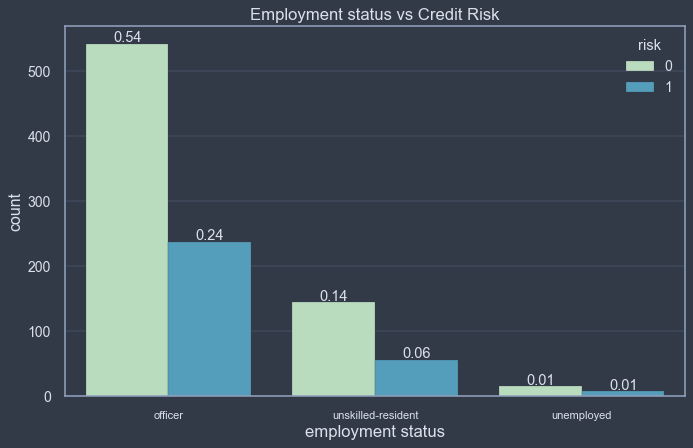

--------------------------------------------------------------------------------
high credit risk: officials: 237 
high credit risk: unemployed: 7 
high credit risk unskilled-resident: 56

low credit risk: officials: 541 
low credit risk: unemployed: 15 
low credit risk unskilled-resident: 144


In [82]:
# -- Visualization --
fig, ax = plt.subplots(figsize=(10, 6), dpi=80)
ax = sns.countplot(x="employment_status", hue = "risk", data=data, palette="GnBu")
ax.set_xticklabels(ax.get_xticklabels(), size=10)
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 3, 
            '{:1.2f}'.format(height/data.shape[0]), ha="center"
           )
plt.xlabel("employment status", size=15)
plt.title("Employment status vs Credit Risk", size=15)
plt.show()
print("-"*80)
print(f"high credit risk: officials: {len(data.loc[high_cred])}",
      f"\nhigh credit risk: unemployed: {len(data.loc[high_cred_unemp])}",
      f"\nhigh credit risk unskilled-resident: {len(data.loc[high_cred_unskilled])}"
      f"\n\nlow credit risk: officials: {len(data.loc[low_cred])}",
      f"\nlow credit risk: unemployed: {len(data.loc[low_cred_unemp])}",
      f"\nlow credit risk unskilled-resident: {len(data.loc[low_cred_unskilled])}"
     )

- There are officals/who are employed have __lowest credit risk__ and there are some with __high credit risk__. There are total 541 employees with low credit risk and 237 with high credit risk. <br>
- Unskilled resident are maybe those who are neigther employed nor jobless, there should be more details about the categories, therefore I'm living that category as it is.
- Unemployed ones clearly have equal ratio of low and high credit risk. there are 15 with low credit risk and 7 are wiht high credit risk.

In [83]:
def scatters(data, h: str = None, pal: str = None) -> plt.plot:
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9,11))
    sns.scatterplot(x="loan_amt", y="loan_taken_over(months)", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="age",y="loan_amt", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="age",y="loan_taken_over(months)", hue=h, palette=pal, data=data, ax=ax3)
    plt.show()

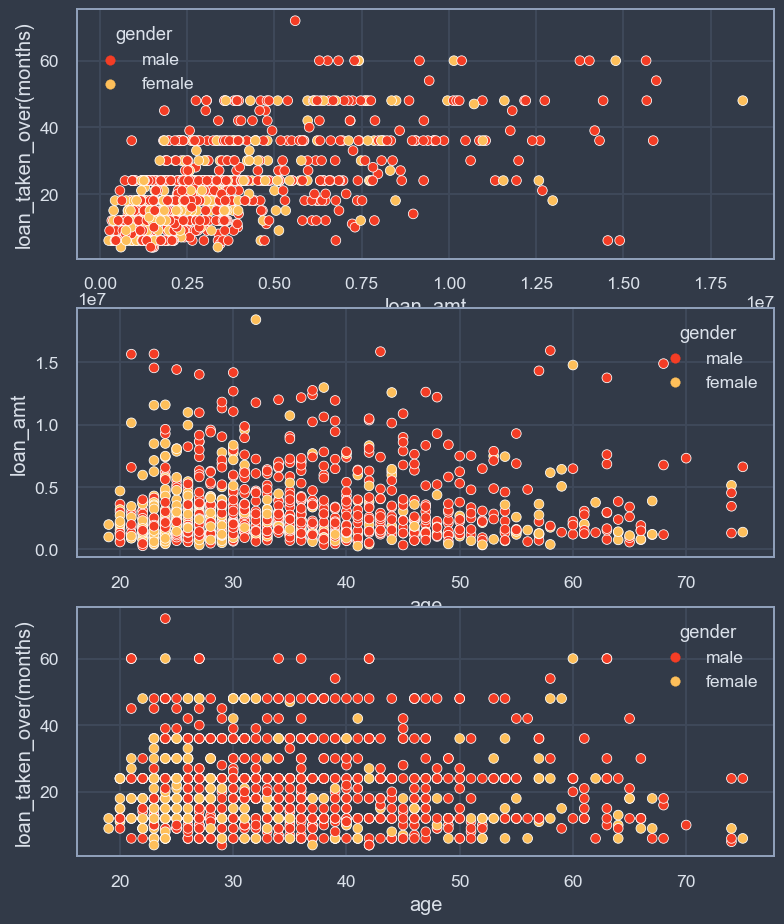

In [84]:
scatters(data, h='gender', pal="YlOrRd_r")

### Notes:

- The general impression is that women tend to be younger than men, however, the top plot shows that there is no clear difference between men and women in terms of amount and duration of the credit. From visual inspection, it seems that there is some __positive correlation__ between __duration__ and __loan amount__, what makes sense.

- Let’s check the __linear correlation__ between __loan amount__ and __duration__.

Pearson correlation: 0.625, P-value: 1.8628512880508719e-109
--------------------------------------------------------------------------------


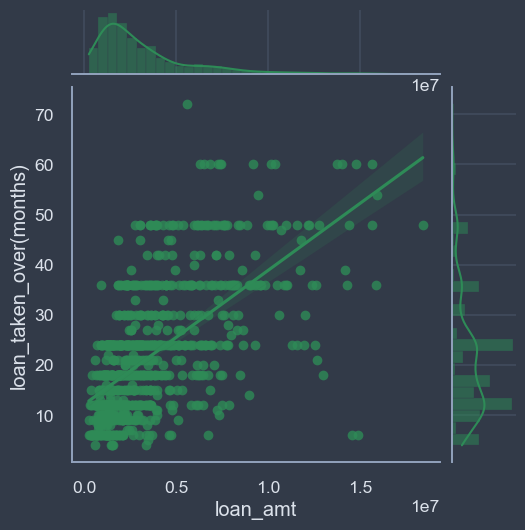

In [85]:
x = data["loan_amt"].values
y = data["loan_taken_over(months)"].values
corr_coef, p_val = pearsonr(x, y)
print(f"Pearson correlation: {round(corr_coef, 3)}, P-value: {p_val}")

print("-"*80)

sns.jointplot(x="loan_amt", y="loan_taken_over(months)", data=data, kind="reg", height=5.5, color="seagreen")
plt.grid(False)
plt.show()

### Notes:

- The plot above shows a linear correlation with Pearson value of __0.63__ and very small __p-value__. That make’s sense because usually, people take bigger credits for longer periods. Below I will analyse linear regression plots with various categorisations.

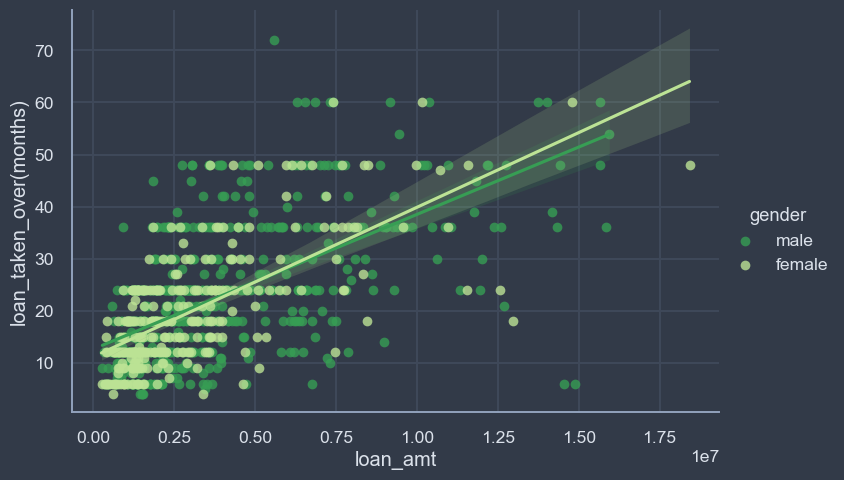

In [86]:
sns.lmplot(data=data, x="loan_amt", y="loan_taken_over(months)", hue="gender", palette="YlGn_r", aspect=1.5, height=5);

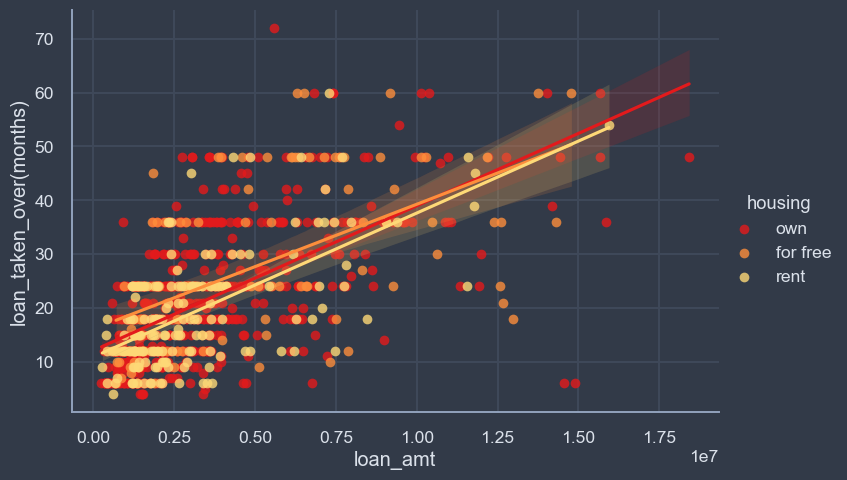

In [87]:
sns.lmplot(data=data, x="loan_amt", y="loan_taken_over(months)", hue="housing", palette="YlOrRd_r", aspect=1.5, height=5)
plt.show()

- The plot above shows similarly that there is no diference betwen housing categories.

- Below I will show “business” area where granted the biggest amount of loans.

In [88]:
data["housing"].value_counts()

own         713
rent        179
for free    108
Name: housing, dtype: int64

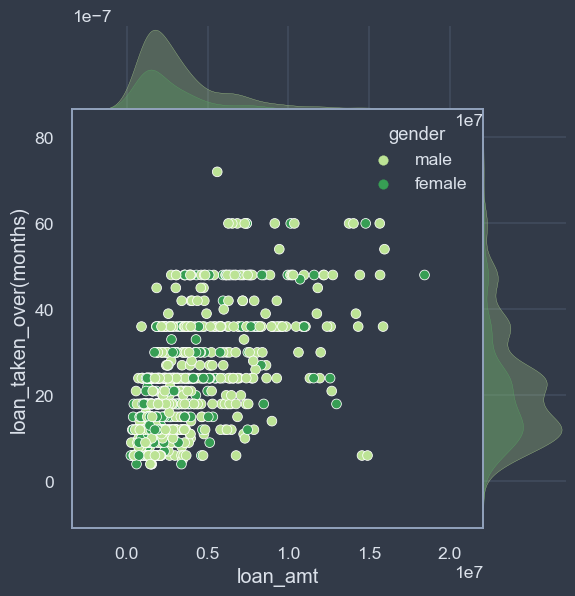

In [89]:
sns.jointplot(data=data, x="loan_amt",y="loan_taken_over(months)",
              hue="gender", space=0, palette="YlGn", kind="scatter"
             )
plt.grid(False)
plt.show()

- As the loan amount is increases the time to pay due increases as well.

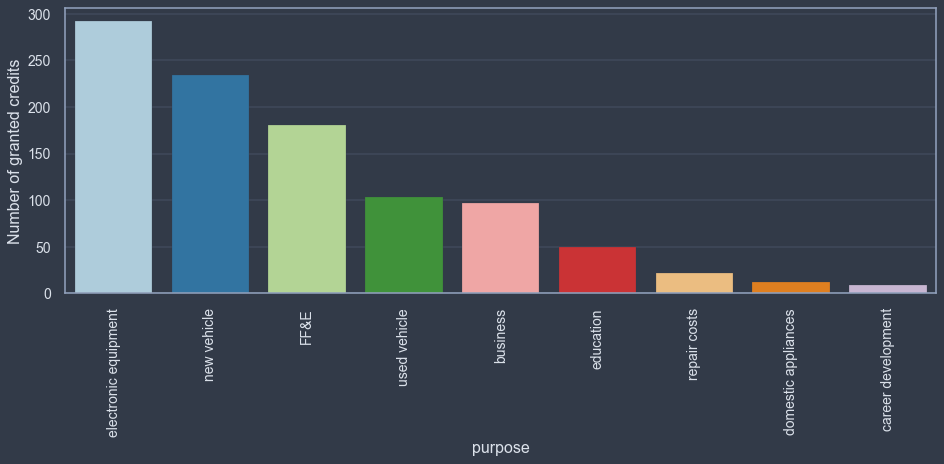

In [90]:
n_credits = data.groupby("purpose")["age"].count().rename("count").reset_index()
n_credits.sort_values(by=["count"], ascending=False, inplace=True)

plt.figure(figsize=(12,6), dpi=80)
bar = sns.barplot(x="purpose",y="count",data=n_credits, palette="Paired")
bar.set_xticklabels(bar.get_xticklabels(), rotation=90)
plt.ylabel("Number of granted credits")
plt.tight_layout()

- The barplot above shows how many credits were granted for various purposes. Most of credits were granted for __electronic equipments__ and __new vehicle__.

- Now I will generate boxplots for detailed analysis of categorical variables.

## Low risk vs High risk:

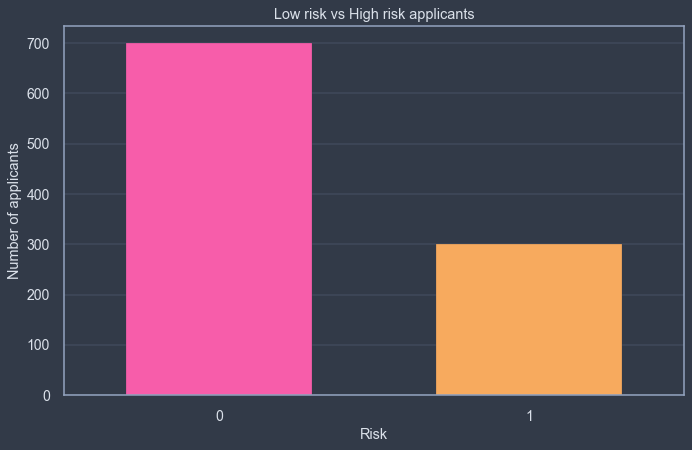

Percentage of low risk cases is: 43%


In [91]:
plt.figure(figsize=(10, 6), dpi=80)
sns.countplot(data=data, x=data.risk, palette="spring", width=.6, saturation=.9, );
plt.title("Low risk vs High risk applicants", size=13)
plt.xlabel("Risk", size=13)
plt.ylabel("Number of applicants", size=13)
plt.show()

low_risk_ppl = data[data['risk']==0]
high_risk_ppl = data[data['risk']==1]

print('Percentage of low risk cases is: {:.0%}'.format(len(high_risk_ppl)/len(low_risk_ppl)))

It is understood that most of the customers are low credit risk, maybe they are earning well, pays their due time to time. To be more precise, the number of customers who are high risks is 183 in total and the number of low risk customers is 517 which means __43%__ of the customers are high risks.

In [92]:
def boxes(x: str, y: str, h: str = None, pal: str = None) -> plt.plot:
    fig, ax = plt.subplots(figsize=(10,6), dpi=80)
    box = sns.boxplot(x=x,y=y, hue=h, data=data, palette=pal, saturation=.9)
    box.set_xticklabels(box.get_xticklabels(), rotation=90, size=13)
    fig.subplots_adjust(bottom=0.2)
    plt.xlabel(x, size=15)
    plt.ylabel(y, size=15)
    plt.tight_layout()

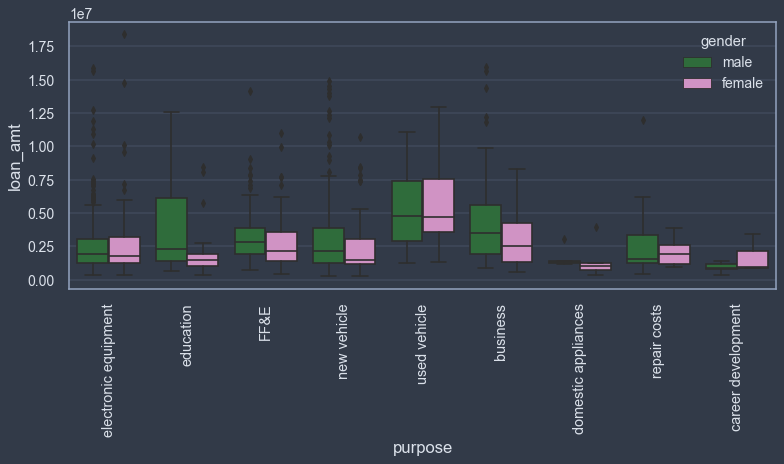

In [93]:
boxes("purpose", "loan_amt", "gender", "cubehelix")

The plot above shows that the biggest amounts are taken for vacations/others, the smallest for domestic appliances. Most of them have outliers on the upper side of the boxes (higher amounts). In most of the cases there is no difference between men and women, despite category vacation/others. But one must remember that there was very little number of credits granted in this category

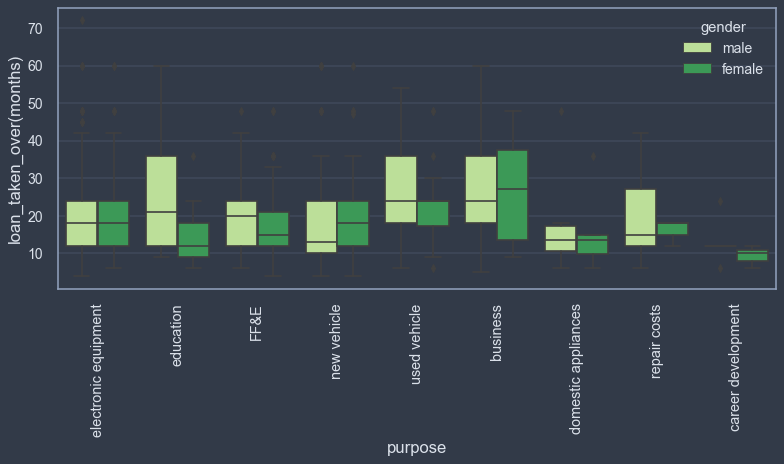

In [94]:
boxes("purpose", "loan_taken_over(months)", "gender", "YlGn")

The boxplot above indicates that generally there is no difference in credit duration between men and women. We can’t see also clear trend between categories with observations that the shortest duration is for domestic appliances. It makes sense as it is in agreement with insights from the previous graph (credit amount) – in this category, there are the lowest amounts of credits.

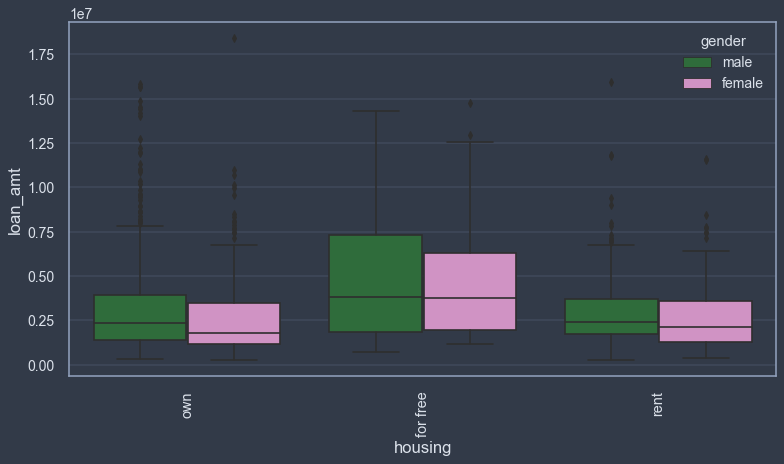

In [95]:
boxes("housing", "loan_amt", "gender", "cubehelix")

In terms of housing category, there is no big difference despite people having “free” housing tend to take slightly bigger credit amounts.

In [96]:
fig = px.scatter_3d(data, 
                    x='loan_amt', 
                    y='loan_taken_over(months)', 
                    z='age', color="gender", 
                    size_max=18, 
                    opacity=0.5
                   )
fig.show()

For clustering, I will create a subset containing only numerical variables (Age, Credit amount, Duration).

In [97]:
# data.to_csv("combined_loan_applicants.csv", index=False)

In [98]:
applicant_id = data.pop("applicant_id")
# risk = data.pop('risk')

In [99]:
data.head()

,age,gender,housing,residency(years),employment_status,at_least_employment(years),at_most_employment(years),loan_taken_over(months),purpose,loan_amt,emi_rate(percent),property,existing_loans(total),loan_history,risk
0,67,male,own,4,officer,7.0,2.746,6,electronic equipment,1169000,4,real estate,2,critical/pending loans at other banks,0
1,22,female,own,2,officer,1.0,4.000,48,electronic equipment,5951000,2,real estate,1,existing loans paid back duly till now,1
2,49,male,own,3,unskilled-resident,4.0,7.000,12,education,2096000,2,real estate,1,critical/pending loans at other banks,0
3,45,male,for free,4,officer,4.0,7.000,42,FF&E,7882000,2,building society savings agreement/life insurance,1,existing loans paid back duly till now,0
4,53,male,for free,4,officer,1.0,4.000,24,new vehicle,4870000,3,car or other,2,delay in paying off loans in the past,1


In [100]:
num_cols = data._get_numeric_data().columns
cluster_data = data.loc[:, num_cols]
cluster_data.shape

(1000, 9)

### Skewness:

In [101]:
def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["age"], ax=ax1, color="seagreen")
    sns.distplot(df["loan_amt"], ax=ax2, color="teal")
    sns.distplot(df["loan_taken_over(months)"], ax=ax3, color="g")
    plt.tight_layout()

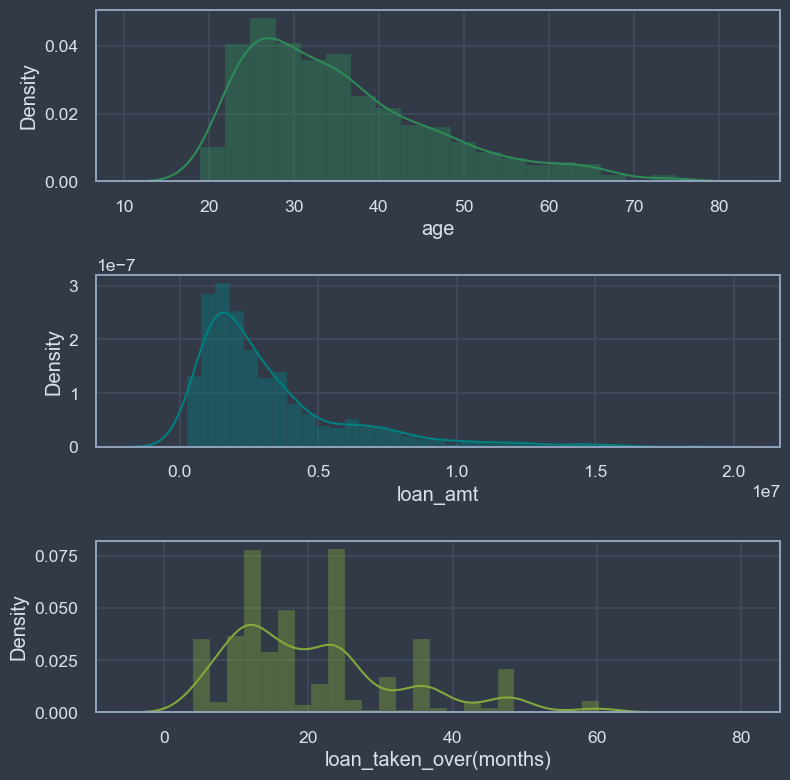

In [102]:
distributions(cluster_data)

,age,residency(years),at_least_employment(years),at_most_employment(years),loan_taken_over(months),loan_amt,emi_rate(percent),existing_loans(total)
0,4.204693,1.386294,1.945910,1.010145,1.791759,13.971659,1.386294,0.693147
1,3.091042,0.693147,0.000000,1.386294,3.871201,15.599070,0.693147,0.000000
2,3.891820,1.098612,1.386294,1.945910,2.484907,14.555541,0.693147,0.000000
3,3.806662,1.386294,1.386294,1.945910,3.737670,15.880092,0.693147,0.000000
4,3.970292,1.386294,0.000000,1.386294,3.178054,15.398604,1.098612,0.693147


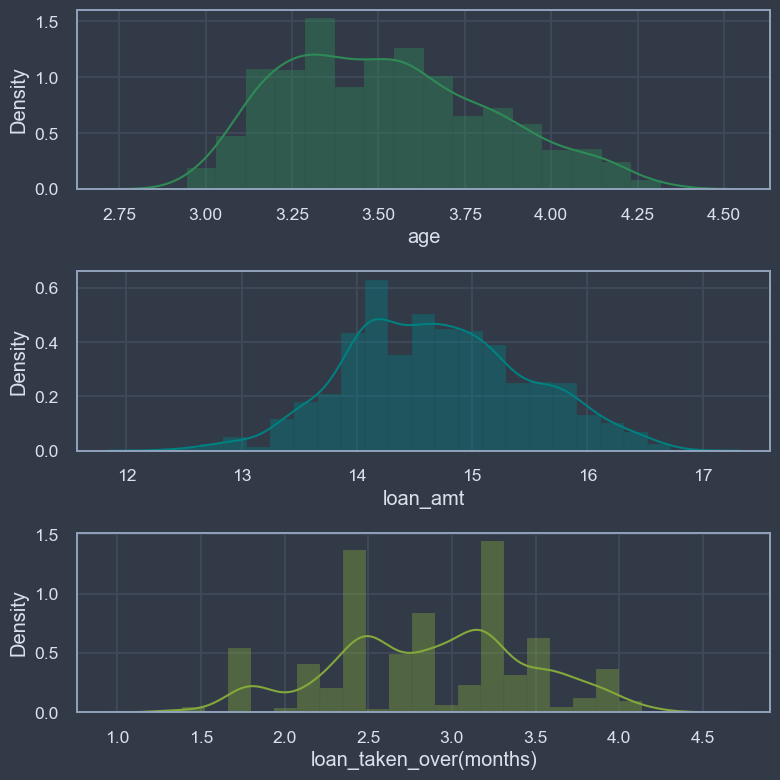

In [103]:
cluster_log = np.log(cluster_data.iloc[:, :-1])
display(cluster_log.head())

distributions(cluster_log)

Indeed, the skewness has been eliminated.

The next step will be centering and scaling of variables – it is required by KMeans algorithm. We will use for that a StandardScaler from sklearn library.

In [104]:
def oneHot_encode(data: pd.DataFrame, cat_cols: list) -> pd.DataFrame:
    if cat_cols != data.select_dtypes(include="object").columns.to_list():
        print("provided columns are not categorical")
        return
    encoder = OneHotEncoder(sparse=False, handle_unknown="ignore").fit(data[cat_cols])
    encoded_cols = list(encoder.get_feature_names(cat_cols))
    data[encoded_cols] = encoder.transform(data[cat_cols])
    data.drop(columns=cat_cols, inplace=True)
    return data

In [105]:
def label_encode(data: pd.DataFrame, cat_cols: list) -> pd.DataFrame:
    encoder = LabelEncoder()
    for col in cat_cols:
        encoder.fit(data[col])
        data[col] = encoder.transform(data[col])
    return data

In [106]:
cluster_log['risk'] = data['risk']
cluster_log.head()

,age,residency(years),at_least_employment(years),at_most_employment(years),loan_taken_over(months),loan_amt,emi_rate(percent),existing_loans(total),risk
0,4.204693,1.386294,1.945910,1.010145,1.791759,13.971659,1.386294,0.693147,0
1,3.091042,0.693147,0.000000,1.386294,3.871201,15.599070,0.693147,0.000000,1
2,3.891820,1.098612,1.386294,1.945910,2.484907,14.555541,0.693147,0.000000,0
3,3.806662,1.386294,1.386294,1.945910,3.737670,15.880092,0.693147,0.000000,0
4,3.970292,1.386294,0.000000,1.386294,3.178054,15.398604,1.098612,0.693147,1


## KMeans Clustering: Customer Segmentation:

In [107]:
inertia = []

for cluster in range(1, 10):
    kmeans = KMeans(n_clusters=cluster, init='k-means++', random_state=42)
    kmeans.fit(cluster_log)
    inertia.append(kmeans.inertia_)

In [108]:
# -- converting the results into a dataframe and plotting them --
df = pd.DataFrame({"cluster": range(1, 10), "inertia": inertia})

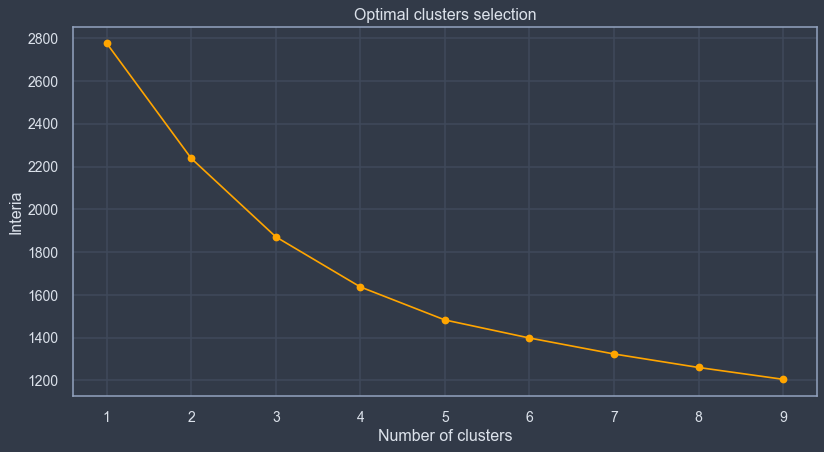

In [109]:
plt.figure(figsize=(12, 6), dpi=80)
plt.plot(df['cluster'], df['inertia'], marker="o", color="orange")
plt.xlabel("Number of clusters")
plt.ylabel("Interia")
plt.title("Optimal clusters selection")
plt.show()

### Notes:

The plot above shows that inertia decreases with increasing number of clusters.

This method allows for assessment of cluster separations and fitting of each observation in its own cluster. The highest score the better. I will perform this analysis for various seeds as well.

In [110]:
Kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=10_000, random_state=42).fit(cluster_log)
ymeans = Kmeans.predict(cluster_log)

In [111]:
acc = silhouette_score(cluster_log, ymeans, metric='euclidean')
print(f"accuracy: {round(acc, 3) * 100} %")

accuracy: 19.6 %


In [112]:
kmeans_2_clusters = KMeans(n_clusters=2, init='k-means++', max_iter=10_000, random_state=0).fit(cluster_log)
accuracy = silhouette_score(cluster_log, kmeans_2_clusters.labels_, metric='euclidean')
print(f"accuracy: {round(accuracy, 3) * 100} %")

accuracy: 17.2 %


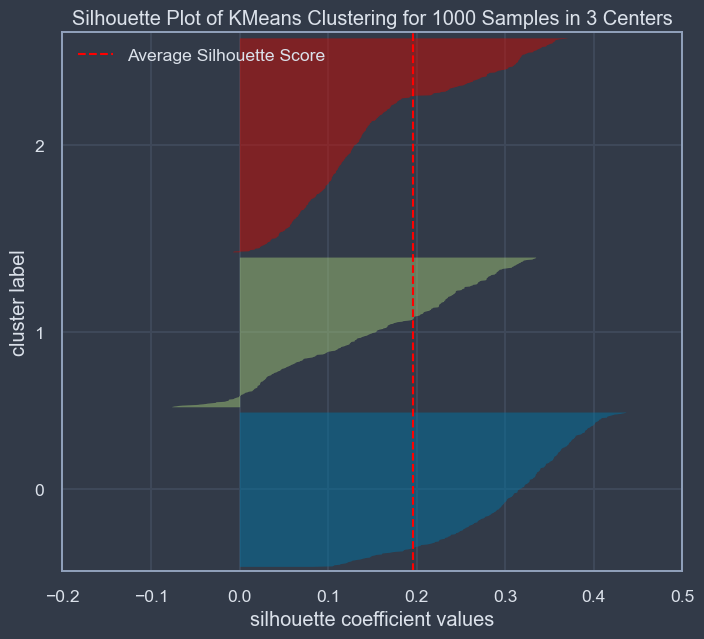

In [113]:
kmeans=KMeans(n_clusters = 3, init = 'k-means++', random_state = 42, max_iter=10_000) 
visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(cluster_log)        
visualizer.show();

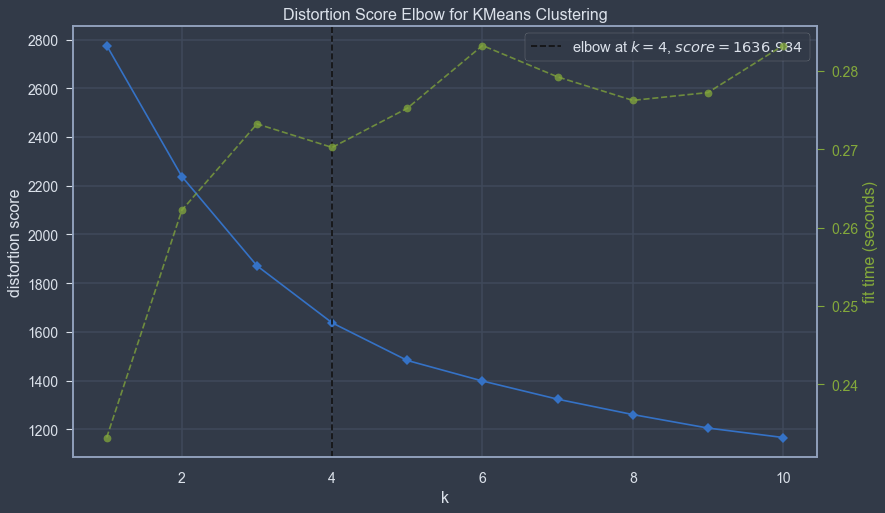

In [114]:
model_two = KMeans(init='k-means++', random_state=42, max_iter=5000)

plt.figure(figsize = (12,7), dpi = 80)
#k is range of number of clusters.
visualizer = KElbowVisualizer(model_two, k=(1,11), timings= True)
visualizer.fit(cluster_log)
visualizer.show()
plt.show()

In [115]:
model_new = KMeans(n_clusters=3, init='k-means++', max_iter=5000, random_state=42).fit(cluster_data)
sil_acc = silhouette_score(cluster_log, model_new.labels_, metric="euclidean")
print(f"{round(sil_acc, 3)}")

0.11


 - Model's accuracy is extremely bad, futhere I've tried to normalize the entire data

## All data:

In [116]:
cat_cols = data.select_dtypes("object").columns.to_list()
label_encode(data, cat_cols)

,age,gender,housing,residency(years),employment_status,at_least_employment(years),at_most_employment(years),loan_taken_over(months),purpose,loan_amt,emi_rate(percent),property,existing_loans(total),loan_history,risk
0,67,1,1,4,0,7.000,2.746,6,5,1169000,4,2,2,1,0
1,22,0,1,2,0,1.000,4.000,48,5,5951000,2,2,1,3,1
2,49,1,1,3,2,4.000,7.000,12,4,2096000,2,2,1,1,0
3,45,1,0,4,0,4.000,7.000,42,0,7882000,2,0,1,3,0
4,53,1,0,4,0,1.000,4.000,24,6,4870000,3,1,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,31,0,1,4,2,4.000,7.000,12,0,1736000,3,2,1,3,0
996,40,1,1,4,0,1.000,4.000,30,8,3857000,4,0,1,3,0
997,38,1,1,4,0,7.000,2.746,12,5,804000,4,1,1,3,0
998,23,1,0,4,0,1.000,4.000,45,5,1845000,4,1,1,3,1


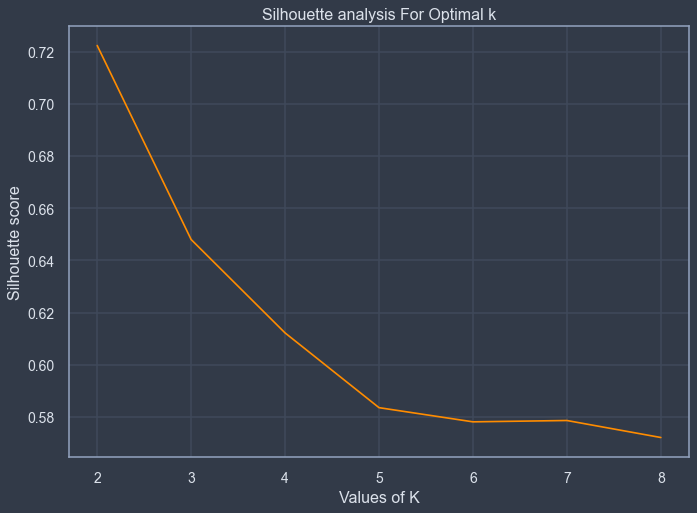

In [117]:
# -- Silhoutte visualizer --
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters: 
    kmeans_third = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=500, random_state=42)
    kmeans_third.fit(data)
    silhouette_avg.append(silhouette_score(data, kmeans_third.labels_))

plt.figure(figsize=(10, 7),dpi=80)
plt.plot(range_n_clusters, silhouette_avg, 'bx-', color="darkorange")
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

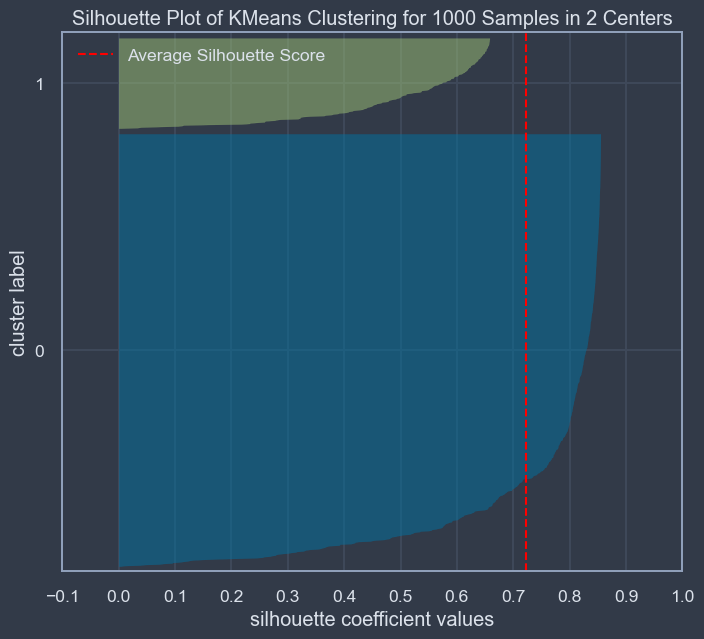

In [118]:
final_model = KMeans(n_clusters=2, random_state=42, init='k-means++', max_iter=10_000)
visualizer = SilhouetteVisualizer(final_model, colors='yellowbrick')
visualizer.fit(data)        
visualizer.show();

In [119]:
# final_model = KMeans(n_clusters=2, random_state=42, init='k-means++', max_iter=10_000).fit(data)
final_acc = silhouette_score(data, final_model.labels_)
print(f"silhouette accuracy: {round(final_acc, 3)}")

silhouette accuracy: 0.722


In [120]:
# clusters_range = range(2, 15)
# random_range = range(0,20)
# results =[]

# for c in clusters_range:
#     for r in random_range:
#         clusterer = KMeans(n_clusters=c, random_state=r)
#         cluster_labels = clusterer.fit_predict(data)
#         silhouette_avg = silhouette_score(data, cluster_labels)
#         results.append([c, r, silhouette_avg])

# result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
# pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

# plt.figure(figsize=(15,6))
# sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
# plt.tight_layout()

## Normalize the data:

In [121]:
# -- Normalizer gives better scoring(accuracy) over other normalization techniques:

cols = data.columns
normalizer = Normalizer().fit(data[cols])
data[cols] = normalizer.transform(data[cols])
data.head()

,age,gender,housing,residency(years),employment_status,at_least_employment(years),at_most_employment(years),loan_taken_over(months),purpose,loan_amt,emi_rate(percent),property,existing_loans(total),loan_history,risk
0,0.000057,8.554320e-07,8.554320e-07,3.421728e-06,0.000000e+00,5.988024e-06,2.349016e-06,0.000005,4.277160e-06,1.0,3.421728e-06,1.710864e-06,1.710864e-06,8.554320e-07,0.000000e+00
1,0.000004,0.000000e+00,1.680390e-07,3.360780e-07,0.000000e+00,1.680390e-07,6.721559e-07,0.000008,8.401949e-07,1.0,3.360780e-07,3.360780e-07,1.680390e-07,5.041170e-07,1.680390e-07
2,0.000023,4.770992e-07,4.770992e-07,1.431298e-06,9.541985e-07,1.908397e-06,3.339695e-06,0.000006,1.908397e-06,1.0,9.541985e-07,9.541985e-07,4.770992e-07,4.770992e-07,0.000000e+00
3,0.000006,1.268714e-07,0.000000e+00,5.074854e-07,0.000000e+00,5.074854e-07,8.880995e-07,0.000005,0.000000e+00,1.0,2.537427e-07,0.000000e+00,1.268714e-07,3.806141e-07,0.000000e+00
4,0.000011,2.053388e-07,0.000000e+00,8.213552e-07,0.000000e+00,2.053388e-07,8.213552e-07,0.000005,1.232033e-06,1.0,6.160164e-07,2.053388e-07,4.106776e-07,4.106776e-07,2.053388e-07


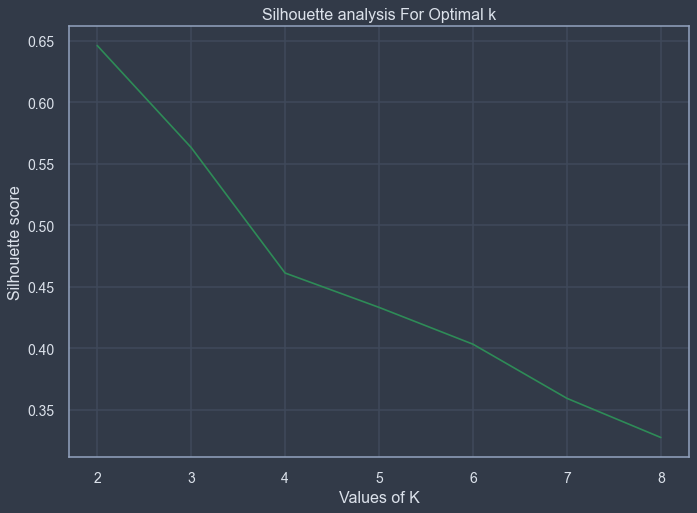

In [122]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []
for num_clusters in range_n_clusters: 
    kmeans_f = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=500, random_state=42, n_init=12)
    kmeans_f.fit(data)
    silhouette_avg.append(silhouette_score(data, kmeans_f.labels_))

plt.figure(figsize=(10, 7),dpi=80)
plt.plot(range_n_clusters, silhouette_avg,'bx-', color="seagreen")
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

- This model is showing better rsults in terms of silhouette accuracy.

silhouette accuracy: 0.646


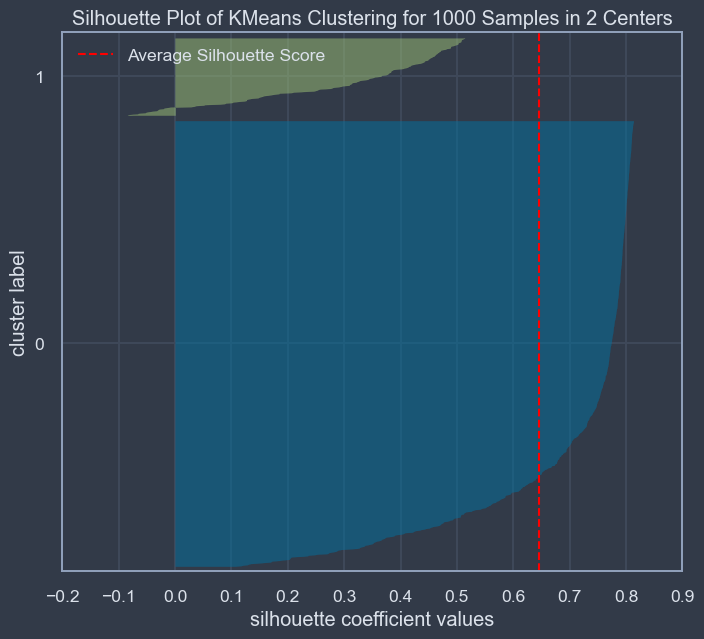

In [123]:
n_kmeans = KMeans(n_clusters=2, init="k-means++", max_iter=10_000, random_state=42, n_init=12).fit(data)
sil_acc = silhouette_score(data, n_kmeans.labels_, metric="euclidean")
print(f"silhouette accuracy: {round(sil_acc, 3)}")

visualizer = SilhouetteVisualizer(n_kmeans, colors='yellowbrick')
visualizer.fit(data)        
visualizer.show();

- Clearly this model is extremly overfitting.
- we can choose no. of clusters equals to 2, that gives an average silhouette score of 0.8, i.e 80%.

In [124]:
# clusters_range = range(2, 15)
# random_range = range(0,20)
# results =[]

# for c in clusters_range:
#     for r in random_range:
#         clusterer = KMeans(n_clusters=c, random_state=r)
#         cluster_labels = clusterer.fit_predict(data)
#         silhouette_avg = silhouette_score(data, cluster_labels)
#         results.append([c, r, silhouette_avg])

# result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
# pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

# plt.figure(figsize=(15,6))
# sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
# plt.tight_layout()

The heatmap above shows silhouette scores for various combinations of random state and number of clusters. The highest scores are for 2 and 3 clusters and they are relatively insensitive to seed.

I will chose 3 clusters to get more insight into data.